In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm, base
%matplotlib inline

# HMM

In [2]:
model = hmm.CategoricalHMM(n_components=3)
model.n_features = 2
model.startprob_ = np.array([.350, .375, .275])
model.transmat_ = np.array([ [.6, .3, .1], [.3, .5, .2], [.1, .3, .6]])
model.emissionprob_ = np.array([ [.5, .5], [.2, .8], [.1, .9]])

observations = 'ININNINNNN'
# Convert observations to a column vector of 0's and 1's
obsSequence = np.array([ ['IN'.find(c)] for c in observations ])

# Forward Algorithm

In [3]:
def alpha(k):
  alphatilde = np.multiply(model.startprob_, np.transpose(model.emissionprob_[:,obsSequence[1]]))[0]
  alpha = np.divide(alphatilde, sum(alphatilde))

  for j in range(1,k+1):
    alphatilde = np.multiply(np.dot(alpha, model.transmat_), np.transpose(model.emissionprob_[:,obsSequence[j]]))[0]
    alpha = np.divide(alphatilde, sum(alphatilde))

  return alpha

filterResults = np.array([alpha(j) for j in range(len(observations))])
filterResults

array([[0.24221453, 0.41522491, 0.34256055],
       [0.20549867, 0.41408332, 0.38041801],
       [0.56545916, 0.30321143, 0.1313294 ],
       [0.32288104, 0.42021451, 0.25690445],
       [0.23879064, 0.42470739, 0.33650196],
       [0.58474835, 0.29584841, 0.11940325],
       [0.33033406, 0.42041003, 0.24925592],
       [0.24189833, 0.42563919, 0.33246248],
       [0.20707283, 0.416886  , 0.37604117],
       [0.19207044, 0.4106347 , 0.39729485]])

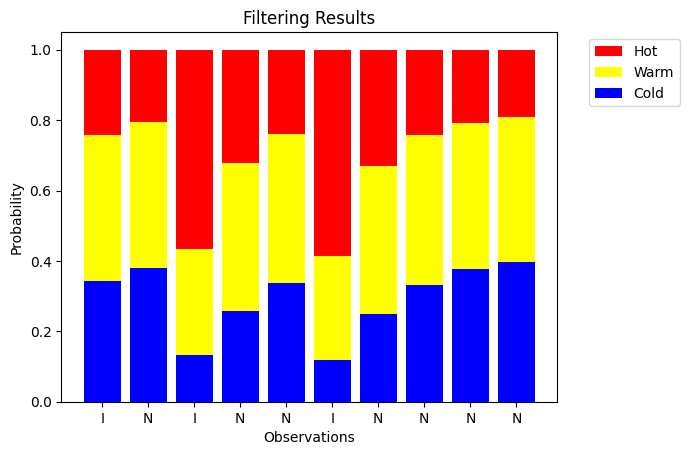

[1 1 0 1 1 0 1 1 1 1]
WWHWWHWWWW
[[0.62637822 0.27817118 0.0954506 ]
 [0.43946342 0.40583118 0.15470539]
 [0.590248   0.29672438 0.11302762]
 [0.34121974 0.43069089 0.22808937]
 [0.32433663 0.43727902 0.23838436]
 [0.51465561 0.32182805 0.16351634]
 [0.26677693 0.42048529 0.31273778]
 [0.19318865 0.41368551 0.39312584]
 [0.17504906 0.40769476 0.41725618]
 [0.1922655  0.41073213 0.39700236]]


In [4]:
f_hot = filterResults[:,0]
f_warm = filterResults[:,1]
f_cold = filterResults[:,2]
ind = [i for i,_ in enumerate(observations)]

plt.bar(ind, f_hot, color='red', label='Hot', bottom = f_warm+f_cold)
plt.bar(ind, f_warm, color='yellow', label='Warm', bottom = f_cold)
plt.bar(ind, f_cold, color='blue', label='Cold')
plt.legend(loc='upper left', bbox_to_anchor=(1.05,1))
plt.xticks(ind, list(observations))
plt.xlabel("Observations")
plt.ylabel("Probability")
plt.title("Filtering Results")
plt.show()

filterMaxs = np.argmax(filterResults, axis=1)
print(filterMaxs)
print(''.join(['HWC'[x] for x in filterMaxs]))

# Find the probability of the internal states at each point in time
smoothingResults = model.predict_proba(obsSequence)
print(smoothingResults)

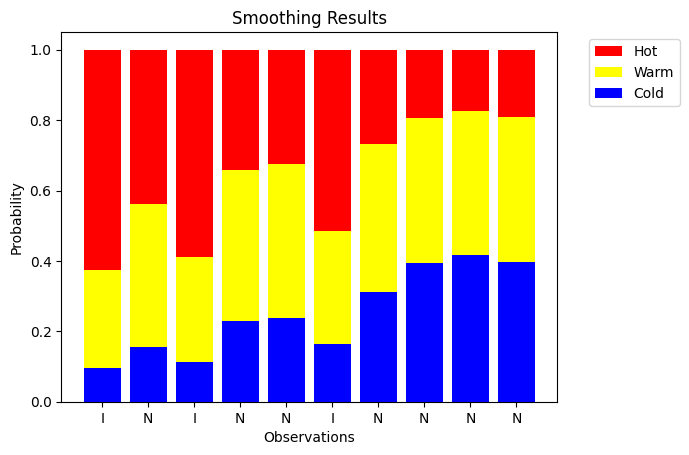

[0 0 0 1 1 0 1 1 2 1]
HHHWWHWWCW


In [5]:
s_hot = smoothingResults[:,0]
s_warm = smoothingResults[:,1]
s_cold = smoothingResults[:,2]
ind = [i for i,_ in enumerate(observations)]

plt.bar(ind, s_hot, color='red', label='Hot', bottom = s_warm+s_cold)
plt.bar(ind, s_warm, color='yellow', label='Warm', bottom = s_cold)
plt.bar(ind, s_cold, color='blue', label='Cold')
plt.legend(loc='upper left', bbox_to_anchor=(1.05,1))
plt.xticks(ind, list(observations))
plt.xlabel("Observations")
plt.ylabel("Probability")
plt.title("Smoothing Results")
plt.show()

smoothingMaxs = np.argmax(smoothingResults, axis=1)
print(smoothingMaxs)
print(''.join(['HWC'[x] for x in smoothingMaxs]))

Observations:          ININNINNNN
Filtering most likely: WWHWWHWWWW
Smoothing most likely: HHHWWHWWCW


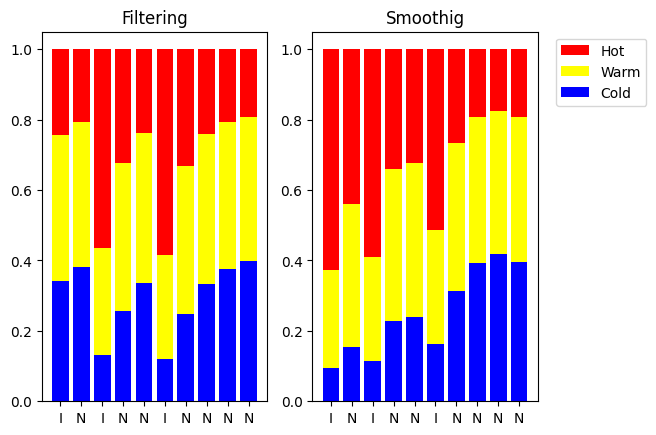

In [6]:
plt.subplot(1,2,1)
plt.bar(ind, f_hot, color='red', label='Hot', bottom = f_warm+f_cold)
plt.bar(ind, f_warm, color='yellow', label='Warm', bottom = f_cold)
plt.bar(ind, f_cold, color='blue', label='Cold')
plt.xticks(ind, list(observations))
plt.title('Filtering')
plt.subplot(1,2,2)
plt.bar(ind, s_hot, color='red', label='Hot', bottom = s_warm+s_cold)
plt.bar(ind, s_warm, color='yellow', label='Warm', bottom = s_cold)
plt.bar(ind, s_cold, color='blue', label='Cold')
plt.legend(loc='upper left', bbox_to_anchor=(1.05,1))
plt.xticks(ind, list(observations))
plt.title('Smoothig')
print('Observations:         ', observations)
print('Filtering most likely:', ''.join(['HWC'[x] for x in filterMaxs]))
print('Smoothing most likely:', ''.join(['HWC'[x] for x in smoothingMaxs]))

# Viterbi

In [7]:
logProb, viterbi = model.decode(obsSequence)
print(logProb)
print(viterbi)
print(''.join(['HWC'[x] for x in viterbi]))
print('Most likely sequence: ', ''.join(['HWC'[x] for x in viterbi]))

-11.938821877950918
[0 0 0 0 0 0 1 1 1 1]
HHHHHHWWWW
Most likely sequence:  HHHHHHWWWW


# Baum Welch

In [8]:
learnedModel = hmm.CategoricalHMM(n_components=3)
learnedModel.n_features = 2
learnedModel.n_iter = 10000
learnedModel.tol = .01
learnedModel.verbose = False
class ThresholdMonitor(base.ConvergenceMonitor):
  @property
  def converged(self):
    return (self.iter == self.n_iter or self.history[-1] >= self.tol)
learnedModel.monitor_ = ThresholdMonitor(learnedModel.n_iter, learnedModel.tol, learnedModel.verbose)
learnedModel.fit(obsSequence)

# Create a longer sequence of observations from our original model
longSequence = np.transpose(model.sample(1000)[0])

# Create a longer sequence of observations from our original model
x = learnedModel.fit(longSequence)
print('Original and learned transition probabilities')
print(model.transmat_)
print(learnedModel.transmat_)
print('Original and learned observation probabilities')
print(model.emissionprob_)
print(learnedModel.emissionprob_)

Fitting a model with 11 free scalar parameters with only 10 data points will result in a degenerate solution.
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'


Original and learned transition probabilities
[[0.6 0.3 0.1]
 [0.3 0.5 0.2]
 [0.1 0.3 0.6]]
[[8.58611215e-18 5.81101317e-57 1.00000000e+00]
 [7.96094168e-01 2.03905832e-01 5.37215178e-62]
 [1.34004419e-58 1.00000000e+00 2.36267303e-14]]
Original and learned observation probabilities
[[0.5 0.5]
 [0.2 0.8]
 [0.1 0.9]]
[[0.33908709 0.66091291]
 [0.17506366 0.82493634]
 [0.36867949 0.63132051]]
